<a href="https://colab.research.google.com/github/Amirgh8080/My-SLFEND/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import f1_score


In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score

# Load CSV file
def load_csv(file_path):
    df = pd.read_csv(file_path)
    return df

# Preprocess the data
def preprocess_data(df, text_column, label_column):
    df = df.dropna(subset=[text_column, label_column])
    df[label_column] = df[label_column].apply(lambda x: 1 if x == 'Real' else 0)
    texts = df[text_column].tolist()
    labels = df[label_column].tolist()
    return texts, labels

# Define dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Define model components
class BertEmbedding(nn.Module):
    def __init__(self, bert_model_name):
        super(BertEmbedding, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]

class LeapGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LeapGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRUCell(input_size, hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size * 2 + input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        outputs = []

        for t in range(seq_len):
            ht = self.gru(x[:, t, :], h)
            context = torch.cat([h, ht, x[:, t, :]], dim=-1)  # Concatenate h, ht, and x[:, t, :]
            pi = self.mlp(context)
            skip_prob = pi[:, 1]

            if skip_prob.mean() >= 0.5:
                h = ht
            outputs.append(h)

        outputs = torch.stack(outputs, dim=1)
        return outputs

class MembershipFunction(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MembershipFunction, self).__init__()
        self.leap_gru = LeapGRU(input_size, hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, 9),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        leap_gru_output = self.leap_gru(x)
        h = leap_gru_output[:, -1, :]  # Use the last hidden state
        g = self.mlp(h)
        return g

class TextCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TextCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, (3, input_size))
        self.conv2 = nn.Conv2d(1, 100, (4, input_size))
        self.conv3 = nn.Conv2d(1, 100, (5, input_size))
        self.fc = nn.Linear(300, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x1 = F.relu(self.conv1(x)).squeeze(3)
        x2 = F.relu(self.conv2(x)).squeeze(3)
        x3 = F.relu(self.conv3(x)).squeeze(3)
        x1 = F.max_pool1d(x1, x1.size(2)).squeeze(2)
        x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)
        x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)
        x = torch.cat([x1, x2, x3], dim=1)
        x = self.dropout(self.fc(x))
        return x

class DCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, (3, input_size))
        self.conv2 = nn.Conv2d(1, 100, (4, input_size))
        self.fc = nn.Linear(200, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x1 = F.relu(self.conv1(x)).squeeze(3)
        x2 = F.relu(self.conv2(x)).squeeze(3)
        x1 = F.max_pool1d(x1, x1.size(2)).squeeze(2)
        x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)
        x = torch.cat([x1, x2], dim=1)
        x = self.dropout(self.fc(x))
        return x

class DPCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DPCNN, self).__init__()
        self.conv = nn.Conv2d(1, 100, (3, input_size))
        self.fc = nn.Linear(100, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.conv(x)).squeeze(3)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        x = self.dropout(self.fc(x))
        return x

class DomainGate(nn.Module):
    def __init__(self, input_size):
        super(DomainGate, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 9),
            nn.Softmax(dim=-1)
        )

    def forward(self, g):
        alpha = self.mlp(g)
        return alpha

class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 384),  # 1152 input units, 384 hidden units
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(384, 1),
            nn.Sigmoid()
        )

    def forward(self, v):
        y_hat = self.mlp(v)
        return y_hat

class SLFENDModel(nn.Module):
    def __init__(self):
        super(SLFENDModel, self).__init__()
        self.bert = BertEmbedding('bert-base-uncased')
        self.membership_function = MembershipFunction(input_size=768, hidden_size=256)
        self.experts = nn.ModuleList([
            TextCNN(768, 128),
            DCNN(768, 128),
            DPCNN(768, 128)
        ] * 3)  # 9 experts
        self.domain_gate = DomainGate(9)
        self.classifier = Classifier(128 )  # Corrected to match 128 features * 9 experts

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask)
        # print(f'bert_output: {bert_output.shape}')
        soft_labels = self.membership_function(bert_output)
        # print(f'soft_labels: {soft_labels.shape}')

        # Compute expert outputs
        expert_outputs = [expert(bert_output) for expert in self.experts]
        expert_outputs = torch.stack(expert_outputs, dim=1)  # Stack to create a tensor of shape [batch_size, num_experts, features]
        # print(f'expert_outputs: {expert_outputs.shape}')

        alpha = self.domain_gate(soft_labels)  # Alpha of shape [batch_size, num_experts]
        # print(f'alpha: {alpha.shape}')

        # Ensure alpha has the same shape as expert_outputs for the purpose of element-wise multiplication
        alpha = alpha.unsqueeze(-1)  # Shape becomes [batch_size, num_experts, 1]
        # print(f'alpha.unsqueeze(-1): {alpha.shape}')

        v = (expert_outputs * alpha).sum(dim=1)  # Element-wise multiplication and then sum across experts
        # print(f'v: {v.shape}')

        # Concatenate expert outputs
        v = v.view(v.size(0), -1)  # Flatten to shape [batch_size, 1152]
        # print(f'v after view: {v.shape}')

        y_hat = self.classifier(v)
        # print(f'y_hat: {y_hat.shape}')
        return y_hat

# Load and preprocess data
file_path = '/content/Fake_Real_Data.csv'
df = load_csv(file_path)

print(df.info())
print(df.shape)

text_column = 'Text'
label_column = 'label'
texts, labels = preprocess_data(df, text_column, label_column)

# print(f'Number of texts: {len(texts)}')
# print(f'Number of labels: {len(labels)}')

# Create DataLoader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 170

train_texts, train_labels = texts[:int(0.8*len(texts))], labels[:int(0.8*len(labels))]
val_texts, val_labels = texts[int(0.8*len(texts)):int(0.9*len(texts))], labels[int(0.8*len(labels)):int(0.9*len(labels))]
test_texts, test_labels = texts[int(0.9*len(texts)):], labels[int(0.9*len(labels)):]

train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer, max_len)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Instantiate model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SLFENDModel().to(device)

# Function to validate DataLoader and model input shapes
def validate_dataloader_and_model(model, dataloader):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            print(f'input_ids: {input_ids.shape}')
            print(f'attention_mask: {attention_mask.shape}')
            print(f'labels: {labels.shape}')
            outputs = model(input_ids, attention_mask)
            print(f'outputs: {outputs.shape}')
            break  # Only validate the first batch

# Validate the DataLoader and model input shapes
validate_dataloader_and_model(model, train_loader)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9900 entries, 0 to 9899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    9900 non-null   object
 1   label   9900 non-null   object
dtypes: object(2)
memory usage: 154.8+ KB
None
(9900, 2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

input_ids: torch.Size([16, 170])
attention_mask: torch.Size([16, 170])
labels: torch.Size([16])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


outputs: torch.Size([16, 1])


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [3]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=2e-5):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_f1 = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss, val_f1 = evaluate_model(model, val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss}, Val F1: {val_f1}')

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

def evaluate_model(model, val_loader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    criterion = nn.BCELoss()

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask).squeeze(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.cpu().numpy() > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

    val_f1 = f1_score(all_labels, all_preds)
    return val_loss / len(val_loader), val_f1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SLFENDModel().to(device)
train_model(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc
criterion = nn.BCELoss()
def train_model(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=2e-5, c=nn.BCELoss()):
    criterion = c
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_f1 = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_aucs = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_labels = []
        all_preds = []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = outputs.detach().cpu().numpy() > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_acc = accuracy_score(all_labels, all_preds)
        train_accs.append(train_acc)
        train_auc = roc_auc_score(all_labels, all_preds)
        train_aucs.append(train_auc)

        val_loss, val_f1, val_acc, val_auc = evaluate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_aucs.append(val_auc)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val F1: {val_f1}, Val ACC: {val_acc}, Val AUC: {val_auc}')

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

    test_loss, test_f1, test_acc, test_auc = evaluate_model(model, test_loader)
    print(f'Test Loss: {test_loss}, Test F1: {test_f1}, Test ACC: {test_acc}, Test AUC: {test_auc}')

    return train_losses, val_losses, train_accs, val_accs, train_aucs, val_aucs, test_loss, test_f1, test_acc, test_auc

def evaluate_model(model, val_loader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask).squeeze(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.detach().cpu().numpy() > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

    val_loss /= len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_auc = roc_auc_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds)

    return val_loss, val_f1, val_acc, val_auc


In [15]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs, train_aucs, val_aucs, dropout_values):
    epochs = range(1, len(train_losses) + 1)

    # Plot Dropout value
    # plt.figure(figsize=(10, 5))
    # plt.plot(epochs, dropout_values, 'b-', label='Dropout')
    # plt.xlabel('Epochs')
    # plt.ylabel('Dropout')
    # plt.title('Dropout Schedule')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # Plot ACC vs EPOCH
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accs, 'r-', label='Train ACC')
    plt.plot(epochs, val_accs, 'g-', label='Val ACC')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Bar plot of precision, recall, AUC, ACC
    labels = ['Train', 'Val']
    metrics = ['Precision', 'Recall', 'AUC', 'ACC']
    train_metrics = [train_recall, train_auc, train_acc]
    val_metrics = [val_recall, val_auc, val_acc]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width/2, train_metrics, width, label='Train')
    rects2 = ax.bar(x + width/2, val_metrics, width, label='Val')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Metrics by dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    fig.tight_layout()

    plt.show()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/10, Train Loss: 0.08231322114694525, Val Loss: 0.0011817656322232178, Val F1: 1.0, Val ACC: 1.0, Val AUC: 1.0
Epoch 2/10, Train Loss: 0.004105584705812913, Val Loss: 0.0003798974573709852, Val F1: 1.0, Val ACC: 1.0, Val AUC: 1.0
Epoch 3/10, Train Loss: 0.004440608453546472, Val Loss: 0.0003073362942462066, Val F1: 1.0, Val ACC: 1.0, Val AUC: 1.0
Epoch 4/10, Train Loss: 0.0010927032339774693, Val Loss: 9.104341346932004e-05, Val F1: 1.0, Val ACC: 1.0, Val AUC: 1.0
Epoch 5/10, Train Loss: 9.423991196496045e-05, Val Loss: 3.87284362072786e-05, Val F1: 1.0, Val ACC: 1.0, Val AUC: 1.0
Epoch 6/10, Train Loss: 0.0011764077321357845, Val Loss: 4.8707950026578e-05, Val F1: 1.0, Val ACC: 1.0, Val AUC: 1.0
Epoch 7/10, Train Loss: 0.0013593475161817906, Val Loss: 6.132892233454772e-05, Val F1: 1.0, Val ACC: 1.0, Val AUC: 1.0
Epoch 8/10, Train Loss: 6.768659768200414e-05, Val Loss: 2.1833118250557867e-05, Val F1: 1.0, Val ACC: 1.0, Val AUC: 1.0
Epoch 9/10, Train Loss: 3.65005012641595e-05, 

ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

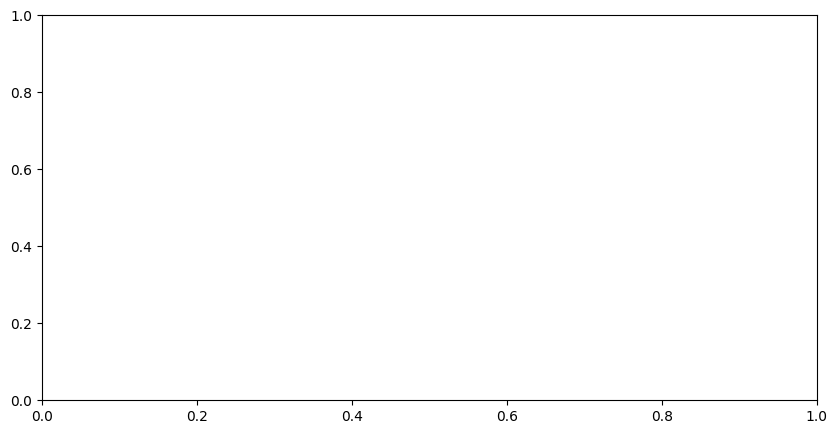

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SLFENDModel().to(device)



train_losses, val_losses, train_accs, val_accs, train_aucs, val_aucs, test_loss, test_f1, test_acc, test_auc = train_model(model, train_loader, val_loader, test_loader)

# Example dropout values
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.5]




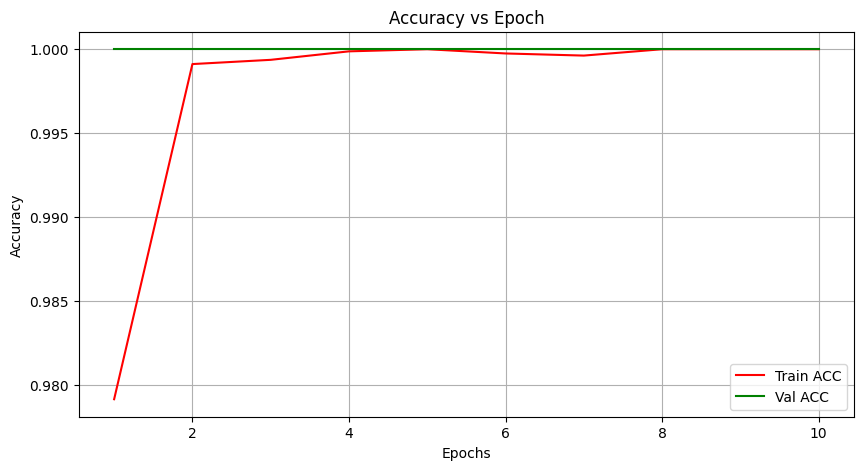

NameError: name 'train_recall' is not defined

In [16]:
# Plot metrics
plot_metrics(train_losses, val_losses, train_accs, val_accs, train_aucs, val_aucs, dropout_values)

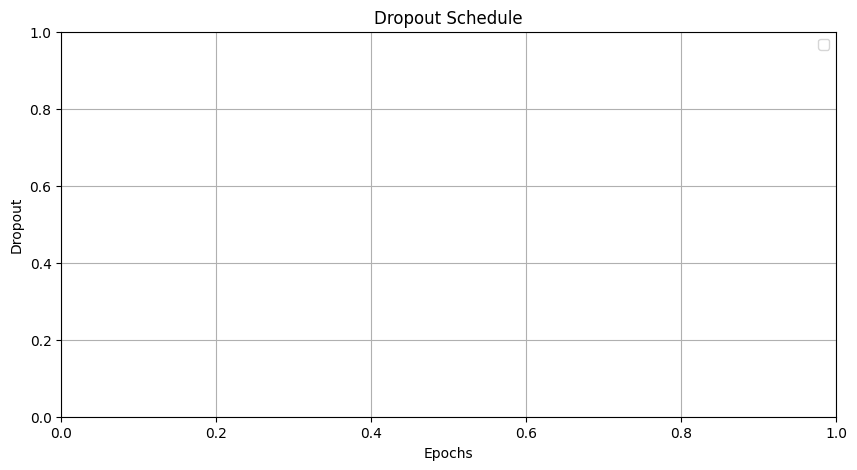

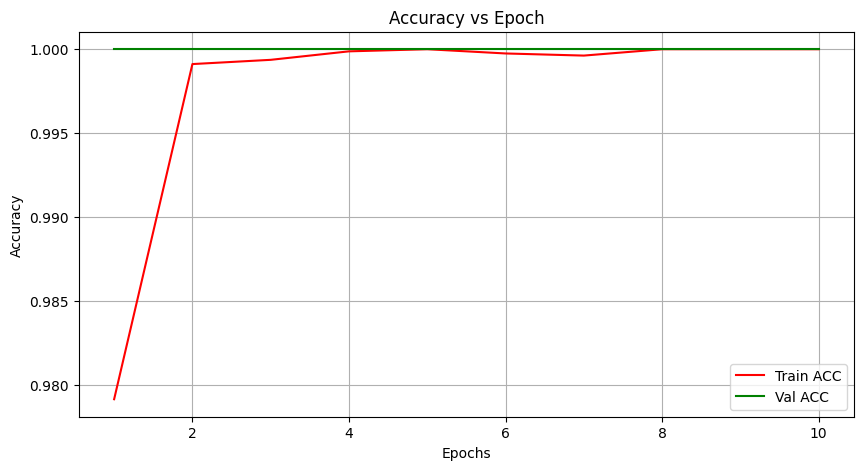

NameError: name 'train_precision' is not defined

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, f1_score


def train_model(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=2e-5):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_f1 = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_aucs = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_labels = []
        all_preds = []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = outputs.detach().cpu().numpy() > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_acc = accuracy_score(all_labels, all_preds)
        train_accs.append(train_acc)
        train_auc = roc_auc_score(all_labels, all_preds)
        train_aucs.append(train_auc)

        val_loss, val_f1, val_acc, val_auc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_aucs.append(val_auc)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val F1: {val_f1}, Val ACC: {val_acc}, Val AUC: {val_auc}')

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

    test_loss, test_f1, test_acc, test_auc = evaluate_model(model, test_loader, criterion)
    print(f'Test Loss: {test_loss}, Test F1: {test_f1}, Test ACC: {test_acc}, Test AUC: {test_auc}')

    return train_losses, val_losses, train_accs, val_accs, train_aucs, val_aucs, test_loss, test_f1, test_acc, test_auc

def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask).squeeze(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.detach().cpu().numpy() > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

    val_loss /= len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_auc = roc_auc_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds)

    return val_loss, val_f1, val_acc, val_auc

def plot_metrics(train_losses, val_losses, train_accs, val_accs, train_aucs, val_aucs, dropout_values):
    epochs = range(1, len(train_losses) + 1)

    # Plot Dropout value
    plt.figure(figsize=(10, 5))
    # plt.plot(epochs, dropout_values, 'b-', label='Dropout')
    plt.xlabel('Epochs')
    plt.ylabel('Dropout')
    plt.title('Dropout Schedule')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ACC vs EPOCH
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accs, 'r-', label='Train ACC')
    plt.plot(epochs, val_accs, 'g-', label='Val ACC')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Bar plot of precision, recall, AUC, ACC
    labels = ['Train', 'Val']
    metrics = ['Precision', 'Recall', 'AUC', 'ACC']
    train_metrics = [train_precision, train_recall, train_auc, train_acc]
    val_metrics = [val_precision, val_recall, val_auc, val_acc]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width/2, train_metrics, width, label='Train')
    rects2 = ax.bar(x + width/2, val_metrics, width, label='Val')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Metrics by dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    fig.tight_layout()

    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SLFENDModel().to(device)



# train_losses, val_losses, train_accs, val_accs, train_aucs, val_aucs, test_loss, test_f1, test_acc, test_auc = train_model(model, train_loader, val_loader, test_loader)

# Example dropout values
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.5]

# Plot metrics
plot_metrics(train_losses, val_losses, train_accs, val_accs, train_aucs, val_aucs, dropout_values)
